**3. Tumour Segmentation**
=

This section focuses on the segmentation of breast cancer tumours using different model architectures, including U-Net, U-Net++, and DeepLabV3. We first employ a custom U-Net implemented in PyTorch and trained from scratch. Subsequently, we evaluate U-Net, U-Net++, and DeepLabV3 models from the `segmentation_models_pytorch` package, pretrained on the ImageNet dataset. These pretrained models are fine-tuned by training their decoders while keeping the encoders frozen.

# 3.1. Imports

First we need to import all the packages that we are going to need for the project.

In [3]:
!pip install segmentation_models_pytorch
!pip install openpyxl
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 21.9 MB/s eta 0:00:00


In [4]:
from google.colab import drive
from PIL import Image

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchmetrics
import time
import random
import pandas as pd
import albumentations as A
import segmentation_models_pytorch as smp

Then, we mount the drive to get access to the dataset.

In [5]:
drive.mount('/content/drive')
pathRoot = '/content/drive/MyDrive/Colab Notebooks/Admeav/FinalProjectAdmeav'

Mounted at /content/drive


# 3.2. PyTorch Dataset

In the last section, we preprocessed and structured the data as follows:
- DATASET
  - TRAIN
    - IMAGES
    - MASKS
  - VALIDATION
    - IMAGES
    - MASKS
  - TEST
    - IMAGES
    - MASKS

In order to train, validate and test a segmentation model we first need to create a PyTorch dataset to read each image and its mask.

In [4]:
class BreastCancerDataset(torch.utils.data.Dataset):
  def __init__(self, fol: str, aug = None, tra = None):
    super(BreastCancerDataset, self).__init__()
    self.imgFol = os.path.join(fol, 'IMAGES')
    self.masFol = os.path.join(fol, 'MASKS')
    self.aug = aug
    self.tra = tra
    self.imgLis = sorted(os.listdir(self.imgFol))

  def __getitem__(self, idx):

    # Read image
    img = cv2.imread(
      os.path.join(self.imgFol, self.imgLis[idx]),
      cv2.IMREAD_COLOR
    )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0

    # Read mask
    mas = cv2.imread(
      filename = os.path.join(self.masFol, self.imgLis[idx]),
      flags = cv2.IMREAD_GRAYSCALE
    )
    mas = (mas > 0).astype(np.float32)

    # Augmentations
    if self.aug:
      aug = self.aug(image = img, mask = mas)
      img, mas = aug['image'], aug['mask']

    # SMP preprocessing
    if self.tra is not None:
      img = self.tra(img)

    # To tensor
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    mas = torch.from_numpy(mas).unsqueeze(0).float()

    return img, mas

  def __len__(self):
    return len(self.imgLis)

# 3.3. Model Architecture

In this part we implement the custom U-Net architecture. The model is composed of three main components: an encoder, a decoder, and a wrapper module that integrates both parts using skip connections to improve segmentation performance. Pretrained architectures are already defined in the `segmentation_models_pytorch` package, and it's only necessary to import them.

In [17]:
def convBlock(inChannels: int, outChannels: int, k: int):
  return torch.nn.Sequential(
    torch.nn.Conv2d(
      in_channels = inChannels,
      out_channels = outChannels,
      kernel_size = (k, k),
      stride = 1,
      padding = 'same',
      bias = False
    ),
    torch.nn.BatchNorm2d(outChannels),
    torch.nn.ReLU(inplace = True),
    torch.nn.Conv2d(
      in_channels = outChannels,
      out_channels = outChannels,
      kernel_size = (3, 3),
      stride = 1,
      padding = 'same',
      bias = False
    ),
    torch.nn.BatchNorm2d(outChannels),
    torch.nn.ReLU(inplace = True)
  )

#------------------------------------------------------------------------------#

def up(inChannels: int, outChannels: int, k: int):
  return torch.nn.Sequential(
    torch.nn.ConvTranspose2d(
      in_channels = inChannels,
      out_channels = outChannels,
      kernel_size = (k, k),
      stride = k
    )
  )

#------------------------------------------------------------------------------#

class Encoder(torch.nn.Module):
  def __init__(
    self,
    inChannels: int = 1,
    initChannels: int = 16,
    depthLevels: int = 4,
    dropout: float = 0.2
  ):
    super(Encoder, self).__init__()
    self.depthLevels = depthLevels

    # Initialize dropout
    self.dropout = torch.nn.Dropout(p = dropout)

    # Initialize list of modules
    self.layers = torch.nn.ModuleList()

    # Initialize out channels
    outChannels = initChannels

    # Loop to generate all layers
    for i in range(depthLevels):

      # Convolutional block
      self.layers.append(
        convBlock(
          inChannels = inChannels,
          outChannels = outChannels,
          k = 3
        )
      )

      # Max pooling
      self.layers.append(
        torch.nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
      )

      # Update in and out channels
      inChannels = outChannels
      outChannels = outChannels * 2

    # Bottle neck (last layer of the encoder)
    self.layers.append(
      convBlock(
        inChannels = inChannels,
        outChannels = outChannels,
        k = 3
      )
    )

    # Save feature dimensions
    self.featureDim = outChannels

  def forward(self, x: torch.tensor):
    features = list()

    # Forward loop
    for i in range(self.depthLevels):
      x = self.layers[2 * i](x)
      features.append(x)
      x = self.layers[2 * i + 1](x)
    x = self.dropout(self.layers[-1](x))
    features.append(x)
    return features

#------------------------------------------------------------------------------#

class Decoder(torch.nn.Module):
  def __init__(
    self,
    inChannels: int,
    nClasses: int = 1,
    depthLevels: int = 4,
    skipConnections: bool = True
  ):
    super(Decoder, self).__init__()
    self.depthLevels = depthLevels
    self.skipConnections = skipConnections

    # Initialize list of modules
    self.layers = torch.nn.ModuleList()

    # Initialize out channels
    outChannels = inChannels // 2

    # Loop to generate all layers
    for _ in range(depthLevels):

      # Up block
      self.layers.append(
        up(
          inChannels = inChannels,
          outChannels = outChannels,
          k = 2
        )
      )

      # Convolutional block
      self.layers.append(
        convBlock(
          inChannels = outChannels * 2 if self.skipConnections else outChannels,
          outChannels = outChannels,
          k = 3
        )
      )

      # Update in and out channels
      inChannels = outChannels
      outChannels = inChannels // 2

    # Final (last layer of the decoder)
    self.layers.append(
      torch.nn.Conv2d(
        in_channels = inChannels,
        out_channels = nClasses,
        kernel_size = (3, 3),
        stride = 1,
        padding = 'same',
        bias = False
      )
    )

  def forward(self, features: list):

    # Get bottleneck features
    x = features[-1]

    # Forward loop with or without skip-connections
    for i in range(self.depthLevels):
      x = self.layers[2 * i](x)
      if self.skipConnections:
        x = torch.cat([x, features[-(i + 2)]], dim = 1)
      x = self.layers[2 * i + 1](x)
    return self.layers[-1](x)

#-----------------------------------------------------------------------------#

class UNet(torch.nn.Module):
  def __init__(
    self,
    inChannels: int = 3,
    nClasses: int = 1,
    initChannels: int = 16,
    depthLevels: int = 4,
    dropout: float = 0.2,
    skipConnections: bool = True
  ):
    super(UNet, self).__init__()

    # Encoder
    self.encoder = Encoder(
      inChannels = inChannels,
      initChannels = initChannels,
      depthLevels = depthLevels,
      dropout = dropout
    )

    # Decoder
    self.decoder = Decoder(
      inChannels = self.encoder.featureDim,
      nClasses = nClasses,
      depthLevels = depthLevels,
      skipConnections = skipConnections
    )

  def forward(self, x: torch.tensor):
    features = self.encoder(x)
    return self.decoder(features)


# 3.4. Training model

To train the segmentation models, a suitable loss function must first be defined. A weighted combination of Dice loss and binary cross-entropy loss is defined, with weights of 80% and 20%, respectively.

In [6]:
def diceBCELoss(preds: torch.Tensor, targs: torch.Tensor):

  # Compute binary cross entropy
  bce = torch.nn.functional.binary_cross_entropy_with_logits(preds, targs.float())

  # Compute probabilities with a sigmoid function
  preds = torch.sigmoid(preds)

  # Compute intersection and union
  dims = (1, 2, 3)
  inter = (preds * targs).sum(dim = dims)
  union = preds.sum(dim = dims) + targs.sum(dim = dims)

  # Compute dice and return 1 - dice
  dice = (2 * inter + 1e-6) / (union + 1e-6)
  dice = dice.mean()

  return 0.8 * (1 - dice) + 0.2 * bce

Finally, a training function is implemented that incorporates early stopping based on the validation loss, using a patience criterion. During training, both the last and the best model weights are saved at each iteration, where the best model is defined as the one achieving the lowest validation loss.

In [7]:
def train(
  model: torch.nn.Module,
  optimizer,
  criterion,
  epochs: int,
  patience: int,
  dlTrain: torch.utils.data.DataLoader,
  dlVal: torch.utils.data.DataLoader,
  dev: torch.DeviceObjType,
  chkFol: str
):

  # Initialize epoch and counter for early stopping
  epoch = 0
  count = 0

  # Initialize best loss
  bestLoss = np.inf

  # Number of steps for the training and validation dataset
  stepsT = len(dlTrain)
  stepsV = len(dlVal)

  # Logs dataframe
  logs = {
    'epoch': list(),
    'time': list(),
    'lossT': list(),
    'lossV': list()
  }

  # Move model to device
  model.to(device = dev)

  # Traing loop
  while (epoch < epochs) and (count < patience):

    # Initialize time
    t0 = time.time()

    # Update logs
    logs['epoch'].append(epoch)
    logs['lossT'].append(0)
    logs['lossV'].append(0)

    # Set model in training mode
    model.train()

    # Set encoder to eval if pretrained
    if 'SMP_' in chkFol:
      model.encoder.eval()

    # Training batch loop
    for batch in dlTrain:

      # Read batch and move to device
      img, mas = batch
      img = img.to(device = dev)
      mas = mas.to(device = dev)

      # Reset gradient
      optimizer.zero_grad()

      # Forward pass
      preds = model(img)

      # Compute loss
      loss = criterion(preds, mas)

      # Backward pass
      loss.backward()
      optimizer.step()

      # Update logs
      logs['lossT'][-1] += loss.item()

    # Set model in evaluation mode
    model.eval()

    # Disable gradient calculations
    with torch.no_grad():

      # Validation batch loop
      for batch in dlVal:

        # Read batch and move to device
        img, mas = batch
        img = img.to(device = dev)
        mas = mas.to(device = dev)

        # Forward pass
        preds = model(img)

        # Compute loss
        loss = criterion(preds, mas)

        # Update logs
        logs['lossV'][-1] += loss.item()

      # Update logs based on the number of steps
      logs['lossT'][-1] /= stepsT
      logs['lossV'][-1] /= stepsV

    # Calculate time
    t1 = time.time()
    t = (t1 - t0) / 60.0
    logs['time'].append(t)

    # Print progress
    print((
      f'Epoch [{epoch} / {epochs}] | '
      f'Time: {logs['time'][-1]: .2f} | '
      f'T. Loss: {logs['lossT'][-1]: .2f} | '
      f'V. Loss: {logs['lossV'][-1]: .2f} | '
    ))

    # Initialize binary saving variable
    saveLoss = False

    # Check if loss has improved and update counter for early stopping
    if (logs['lossV'][-1] < bestLoss):
        saveLoss = True
        bestLoss = logs['lossV'][-1]
        count = 0
    else:
        count += 1

    # Save last and best model weights
    torch.save(model.state_dict(), f'{chkFol}/last.pth')
    if saveLoss:
        torch.save(model.state_dict(), f'{chkFol}/bestLoss.pth')

    epoch += 1

  # Save logs to excel file
  logs = pd.DataFrame(logs)
  logs.to_excel(f'{chkFol}/logs.xlsx', index = False)

In the subsequent part, the models are trained for up to 100 epochs, employing an early-stopping patience of 10 epochs.

In [20]:
# Check device
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {dev}')

# Model initializations
unetCus = UNet(
  inChannels = 3,
  nClasses = 1,
  initChannels = 16,
  dropout = 0.2,
  depthLevels = 4
)
unetSMP = smp.Unet(
  encoder_name = 'resnet34',
  encoder_weights = 'imagenet',
  in_channels = 3,
  classes = 1
)
unetPPSMP = smp.UnetPlusPlus(
  encoder_name = 'resnet34',
  encoder_weights = 'imagenet',
  in_channels = 3,
  classes = 1
)
deepLabV3SMP = smp.DeepLabV3(
  encoder_name = 'resnet34',
  encoder_weights = 'imagenet',
  in_channels = 3,
  classes = 1
)

# Augmentations
aug = A.Compose([
  A.HorizontalFlip(p = 0.5),
  A.VerticalFlip(p = 0.5),
  A.ColorJitter(
      brightness = 0.2,
      contrast = 0.2,
      saturation = 0.2,
      hue = 0.1,
      p = 0.5
  ),
])

# SMP preprocessing
traSMP = smp.encoders.get_preprocessing_fn(
  encoder_name = 'resnet34',
  pretrained = 'imagenet'
)

# Datasets
dsTrainCus = BreastCancerDataset(
  fol = os.path.join(pathRoot, 'DATASET', 'TRAIN'),
  aug = aug,
  tra = None
)
dsValCus = BreastCancerDataset(
  fol = os.path.join(pathRoot, 'DATASET', 'VALIDATION'),
  aug = None,
  tra = None
)
dsTrainSMP = BreastCancerDataset(
  fol = os.path.join(pathRoot, 'DATASET', 'TRAIN'),
  aug = aug,
  tra = traSMP
)
dsValSMP = BreastCancerDataset(
  fol = os.path.join(pathRoot, 'DATASET', 'VALIDATION'),
  aug = None,
  tra = traSMP
)

# Dataloaders
dlTrainCus = torch.utils.data.DataLoader(
  dataset = dsTrainCus,
  batch_size = 16,
  shuffle = True
)
dlValCus = torch.utils.data.DataLoader(
  dataset = dsValCus,
  batch_size = 16,
  shuffle = False
)
dlTrainSMP = torch.utils.data.DataLoader(
  dataset = dsTrainSMP,
  batch_size = 16,
  shuffle = True
)
dlValSMP = torch.utils.data.DataLoader(
  dataset = dsValSMP,
  batch_size = 16,
  shuffle = False
)

# Pack in list
models = [
  (unetCus, 'CUS_UNET', dlTrainCus, dlValCus),
  (unetSMP, 'SMP_UNET', dlTrainSMP, dlValSMP),
  (unetPPSMP, 'SMP_UNETPP', dlTrainSMP, dlValSMP),
  (deepLabV3SMP, 'SMP_DEEPLABV3', dlTrainSMP, dlValSMP)
]

for (model, name, dlTrain, dlVal) in models:

  # Define criterion and optimizer
  criterion = diceBCELoss

  # Freeze encoder if pretrained
  if 'SMP_' in name:
    for p in model.encoder.parameters():
      p.requires_grad = False

  # Initialize optimizer
  optimizer = torch.optim.AdamW(
    params = [p for p in model.parameters() if p.requires_grad],
    lr = 1e-3,
    weight_decay = 1e-4
  )

  # Train
  train(
    model = model,
    optimizer = optimizer,
    criterion = criterion,
    epochs = 100,
    patience = 10,
    dlTeain = dlTrain,
    dlVal = dlVal,
    dev = dev,
    chkFol = os.path.join(pathRoot, 'CHECKPOINTS', 'SEGMENTATION', name)
  )

Device: cuda


Let's visualize the training curves.

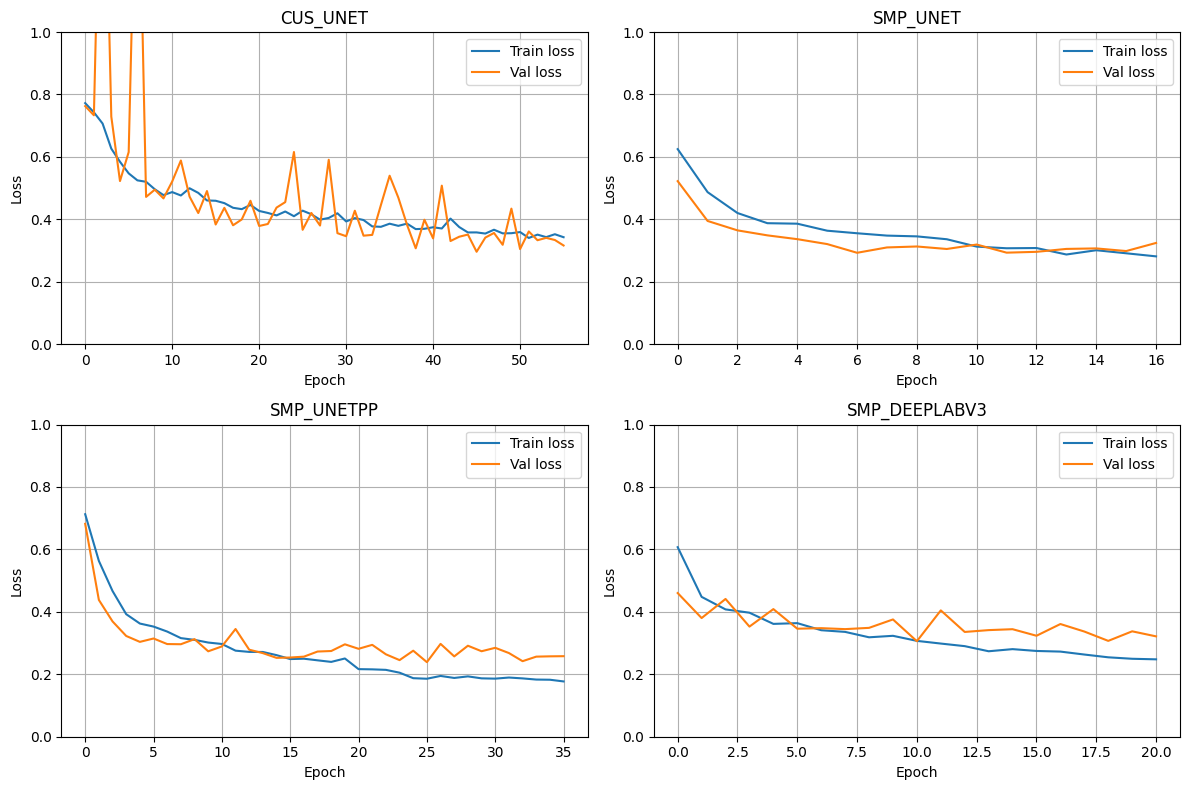

In [9]:
# Pack in list
models = [
  ('CUS_UNET', (0, 0)),
  ('SMP_UNET', (0, 1)),
  ('SMP_UNETPP', (1, 0)),
  ('SMP_DEEPLABV3', (1, 1))
]

# Initialize figure
fig, ax = plt.subplots(2, 2, figsize = (12, 8))

# Loop over model results
for name, (i, j) in models:

  # Get logs for each model
  logs = pd.read_excel(os.path.join(
    pathRoot,
    'CHECKPOINTS',
    'SEGMENTATION',
    name,
    'logs.xlsx'
  ))

  # Plot training and validation curves
  ax[i, j].plot(logs['epoch'], logs['lossT'], label = 'Train loss')
  ax[i, j].plot(logs['epoch'], logs['lossV'], label = 'Val loss')

  # Add title, labels and legend
  ax[i, j].set_title(name)
  ax[i, j].set_xlabel('Epoch')
  ax[i, j].set_ylabel('Loss')
  ax[i, j].set_ylim(0, 1)
  ax[i, j].grid(True)
  ax[i, j].legend()

plt.tight_layout()

# Show figure
plt.show()

# 3.5. Model comparison

In this section we compare the different models evaluated on the test dataset.

In [12]:
def multiMetrics(confmat: torch.tensor):

  # Basic metrics
  TP = torch.diag(confmat)
  FP = confmat.sum(dim = 0) - TP
  FN = confmat.sum(dim = 1) - TP

  # Per-class metrics
  iou = TP / (TP + FP + FN + 1e-8)
  dice = 2 * TP / (2 * TP + FP + FN + 1e-8)
  precision = TP / (TP + FP + 1e-8)
  recall = TP / (TP + FN + 1e-8)
  accuracy = TP.sum() / confmat.sum()

  return iou, dice, precision, recall, accuracy

In [40]:
# Datasets
dsTestCus = BreastCancerDataset(
  fol = os.path.join(pathRoot, 'DATASET', 'TEST'),
  aug = None,
  tra = None
)
dsTestSMP = BreastCancerDataset(
  fol = os.path.join(pathRoot, 'DATASET', 'TEST'),
  aug = None,
  tra = traSMP
)

# Dataloaders
dlTestCus = torch.utils.data.DataLoader(
  dataset = dsTestCus,
  batch_size = 16,
  shuffle = False
)
dlTestSMP = torch.utils.data.DataLoader(
  dataset = dsTestSMP,
  batch_size = 16,
  shuffle = False
)

# Initialize confusion matrix
cm = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5)
cm = cm.to(device = dev)

# Initialize structure for the dataset
str = {
  'MODEL': [],
  'IOU': [],
  'DICE': [],
  'PRECISION': [],
  'RECALL': [],
  'ACCURACY': [],
}

# Pack in list
models = [
  (unetCus, 'CUS_UNET', dlTestCus),
  (unetSMP, 'SMP_UNET', dlTestSMP),
  (unetPPSMP, 'SMP_UNETPP', dlTestSMP),
  (deepLabV3SMP, 'SMP_DEEPLABV3', dlTestSMP)
]

for (model, name, dlTest) in models:

  # Load best weights and move to device
  model.load_state_dict(torch.load(
      os.path.join(pathRoot, 'CHECKPOINTS', name, 'bestLoss.pth'),
      weights_only = True
  ))
  model = model.to(device = dev)

  # Reset confusion matrix
  cm.reset()

  # Set model in evaluation mode
  model.eval()

  # Disable gradient calculations
  with torch.no_grad():

    # Validation batch loop
    for batch in dlTest:

      # Read batch and move to device
      img, mas = batch
      img = img.to(device = dev)
      mas = mas.to(device = dev)

      # Forward pass with sigmoid function
      preds = torch.sigmoid(model(img))

      # Update confusion matrix
      cm.update(preds, mas)

  confmat = cm.compute()
  iou, dice, pre, rec, acc = multiMetrics(confmat)

  str['MODEL'].append(name)
  str['IOU'].append(iou[1].item())
  str['DICE'].append(dice[1].item())
  str['PRECISION'].append(pre[1].item())
  str['RECALL'].append(rec[1].item())
  str['ACCURACY'].append(acc.item())

metrics = pd.DataFrame(str)
metrics.to_excel(os.path.join(pathRoot, 'metrics.xlsx'), index = False)

# Visualize metrics
print(metrics)

           MODEL       IOU      DICE  PRECISION    RECALL  ACCURACY
0       CUS_UNET  0.457081  0.627392   0.688634  0.576154  0.941384
1       SMP_UNET  0.479262  0.647974   0.731294  0.581699  0.945865
2     SMP_UNETPP  0.558648  0.716837   0.797846  0.650762  0.955964
3  SMP_DEEPLABV3  0.513977  0.678976   0.644876  0.716883  0.941937


Finally, let's visualize the predictions on the first test batch for each model.

In [34]:
# Pack in list
models = [
  (None, 'GT', dlTestCus),
  (unetCus, 'CUS_UNET', dlTestCus),
  (unetSMP, 'SMP_UNET', dlTestSMP),
  (unetPPSMP, 'SMP_UNETPP', dlTestSMP),
  (deepLabV3SMP, 'SMP_DEEPLABV3', dlTestSMP)
]

# Initialize figure
fig, axes = plt.subplots(16, 5, figsize=(15, 40))

# Get raw image to plot
imgPlot, _ = next(iter(dlTestCus))

# Loop over models and plot predictions
for j, (model, name, dlTest) in enumerate(models):

  # Get preprocessed image and move to device
  img, mas = next(iter(dlTest))
  img = img.to(dev)

  # If GT then preds is just the mask
  if name == 'GT':
    pred = mas

  # If not GT get predictions
  else:

    # Load best weights and move to device
    model.load_state_dict(torch.load(
        os.path.join(pathRoot, 'CHECKPOINTS', name, 'bestLoss.pth'),
        weights_only = True
    ))
    model = model.to(device = dev)

    # Get predictions
    with torch.no_grad():
      pred = torch.sigmoid(model(img))

  # Squeeze predictions, move back to cpu and threshold
  pred = pred.squeeze(1).cpu().numpy() > 0.5

  # Loop over images within the batch and plot them
  for i in range(16):

    # Get axis
    ax = axes[i, j]
    ax.axis('off')

    # Plot image and overlay prediction
    ax.imshow(imgPlot[i].permute(1, 2, 0).numpy())
    ax.imshow(pred[i], cmap = 'Greens', alpha = 0.4)

    # Plot title
    if i == 0:
      ax.set_title(name, fontsize = 12)

plt.tight_layout()

# Save figure
plt.savefig(
  os.path.join(pathRoot, 'batchPredictionVisualization.png'),
  dpi = 300,
  bbox_inches = 'tight'
)

# Show figure
plt.show()



Output hidden; open in https://colab.research.google.com to view.